# California Air Quality Forecast

## Overview

In this project, I attempted to predict the air quality index for California using Time Series Analysis with Recurrent Neural Network. I want to find out if there was any possible sudden increase in the AQI for the four gases after the COVID pandemic lockdown was lifted in 2020 as factories began their operations and day-to-day activities that involves carbon emissions resumes. The major difference that could have affected any sudden change in the AQI was the absence of the daily pollutants caused by day-to-day activities.

## Research Question

How will the trend of AQI look like after the lockdown in comparison to pre-pandemic years(5 years)?

## Hypothesis

I believe all of the four quality index categories in California will be similar to the pre-pandemic years due to the resumption of production and day-to-day activities after the lockdown has been lifted.

## Importing Libraries

In [1]:
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Data Setup

In [2]:
data = pd.read_csv('pollution_2000_2021.csv')

In [3]:
data.shape

(608699, 24)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608699 entries, 0 to 608698
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               608699 non-null  object 
 1   Year               608699 non-null  int64  
 2   Month              608699 non-null  int64  
 3   Day                608699 non-null  int64  
 4   Address            608699 non-null  object 
 5   State              608699 non-null  object 
 6   County             608699 non-null  object 
 7   City               608699 non-null  object 
 8   O3 Mean            608699 non-null  float64
 9   O3 1st Max Value   608699 non-null  float64
 10  O3 1st Max Hour    608699 non-null  int64  
 11  O3 AQI             608699 non-null  int64  
 12  CO Mean            608699 non-null  float64
 13  CO 1st Max Value   608699 non-null  float64
 14  CO 1st Max Hour    608699 non-null  int64  
 15  CO AQI             608699 non-null  float64
 16  SO

In [5]:
data.describe()

,Year,Month,Day,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
count,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000
mean,2011.040529,6.508670,15.737176,0.028477,0.038903,10.773469,39.112517,0.337258,0.476798,5.971042,5.377387,1.523358,4.210271,8.851891,5.568708,11.738067,23.610711,11.606845,22.124240
std,6.122558,3.310633,8.806949,0.012218,0.015031,3.308152,22.480864,0.282958,0.446321,7.739380,5.142873,2.495094,7.983793,6.774720,10.736164,9.083091,15.412489,7.881014,14.610125
min,2000.000000,1.000000,1.000000,-0.000706,0.000000,7.000000,0.000000,-0.437500,-0.400000,0.000000,0.000000,-2.508333,-2.300000,0.000000,0.000000,-4.629167,-4.400000,0.000000,0.000000
25%,2006.000000,4.000000,8.000000,0.019647,0.029000,9.000000,27.000000,0.179167,0.200000,0.000000,2.000000,0.187500,0.600000,3.000000,0.000000,4.978261,11.200000,5.000000,10.000000
50%,2012.000000,7.000000,16.000000,0.028235,0.038000,10.000000,35.000000,0.262500,0.400000,2.000000,5.000000,0.666667,1.700000,8.000000,1.000000,9.541667,21.800000,9.000000,20.000000
75%,2016.000000,9.000000,23.000000,0.036765,0.048000,11.000000,44.000000,0.420833,0.600000,9.000000,7.000000,1.772727,4.000000,13.000000,6.000000,16.304348,33.700000,20.000000,31.000000
max,2021.000000,12.000000,31.000000,0.107353,0.140000,23.000000,237.000000,7.508333,15.500000,23.000000,201.000000,321.625000,351.000000,23.000000,200.000000,140.650000,269.200000,23.000000,133.000000


In [6]:
#Check for missing values
data.isnull().values.any()

False

In [7]:
data.head()

,Date,Year,Month,Day,Address,State,County,City,O3 Mean,O3 1st Max Value,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000-01-01,2000,1,1,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000-01-02,2000,1,2,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000-01-03,2000,1,3,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000-01-04,2000,1,4,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000-01-05,2000,1,5,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


## Data Preprocessing

In [8]:
data_df = data.drop(['Address'], axis = 1)
data_df.head()

,Date,Year,Month,Day,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000-01-01,2000,1,1,Arizona,Maricopa,Phoenix,0.019765,0.040,10,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000-01-02,2000,1,2,Arizona,Maricopa,Phoenix,0.015882,0.032,10,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000-01-03,2000,1,3,Arizona,Maricopa,Phoenix,0.009353,0.016,9,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000-01-04,2000,1,4,Arizona,Maricopa,Phoenix,0.015882,0.033,9,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000-01-05,2000,1,5,Arizona,Maricopa,Phoenix,0.007353,0.012,9,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


In [9]:
# California AQI
data_california = data_df[data_df['State'] == 'California']
data_california

,Date,Year,Month,Day,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
880,2000-01-01,2000,1,1,California,Contra Costa,Concord,0.019412,0.029,13,...,6,9.0,0.636364,2.0,9,3.0,14.782609,26.0,4,25
881,2000-01-02,2000,1,2,California,Contra Costa,Concord,0.017471,0.032,9,...,23,9.0,1.000000,2.0,5,3.0,16.043478,30.0,21,28
882,2000-01-03,2000,1,3,California,Contra Costa,Concord,0.006353,0.014,8,...,23,22.0,2.454545,4.0,13,6.0,25.521739,40.0,17,38
883,2000-01-04,2000,1,4,California,Contra Costa,Concord,0.008176,0.011,13,...,0,23.0,1.541667,4.0,17,6.0,26.041667,44.0,17,42
884,2000-01-05,2000,1,5,California,Contra Costa,Concord,0.012412,0.022,8,...,23,19.0,1.681818,4.0,10,6.0,23.772727,38.0,17,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594983,2021-09-26,2021,9,26,California,Solano,Vallejo,0.031353,0.037,7,...,0,2.0,0.859091,1.0,10,1.0,1.108696,2.6,15,2
594984,2021-09-27,2021,9,27,California,Solano,Vallejo,0.022353,0.029,20,...,0,2.0,0.836364,1.0,10,1.0,1.508696,3.7,17,3
594985,2021-09-28,2021,9,28,California,Solano,Vallejo,0.029647,0.036,9,...,0,2.0,0.927273,1.0,8,1.0,3.117391,11.8,6,10
594986,2021-09-29,2021,9,29,California,Solano,Vallejo,0.022941,0.033,11,...,0,2.0,1.031818,1.2,13,1.0,5.104348,15.6,22,14


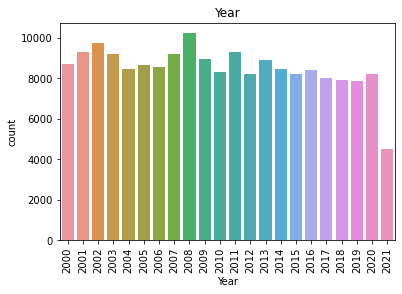

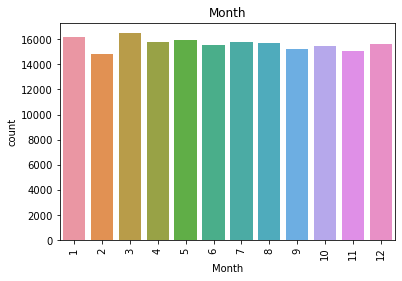

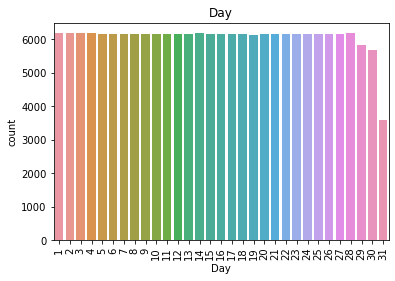

In [10]:
for col in ['Year', 'Month', 'Day']:
    sns.countplot(x = data_california[col])
    plt.title(col)
    plt.xticks(rotation = 90)
    plt.show()

In [11]:
# Setup all four AQIs for state and date
data_california = data_california[['Date', 'State', 'O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']]
data_california['Date'] = pd.to_datetime(data_california['Date'], format = '%Y-%m-%d')
data_california

C:\Users\blahb\AppData\Local\Temp/ipykernel_2536/1062832981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_california['Date'] = pd.to_datetime(data_california['Date'], format = '%Y-%m-%d')


,Date,State,O3 AQI,CO AQI,SO2 AQI,NO2 AQI
880,2000-01-01,California,27,9.0,3.0,25
881,2000-01-02,California,30,9.0,3.0,28
882,2000-01-03,California,13,22.0,6.0,38
883,2000-01-04,California,10,23.0,6.0,42
884,2000-01-05,California,20,19.0,6.0,36
...,...,...,...,...,...,...
594983,2021-09-26,California,34,2.0,1.0,2
594984,2021-09-27,California,27,2.0,1.0,3
594985,2021-09-28,California,33,2.0,1.0,10
594986,2021-09-29,California,31,2.0,1.0,14


## Cleaning Outliers

<AxesSubplot:xlabel='O3 AQI', ylabel='Density'>

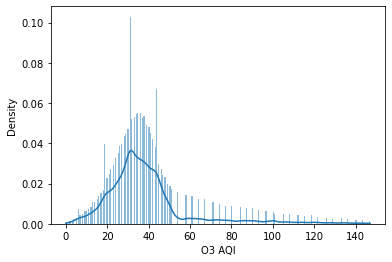

In [12]:
q1 = data_california['O3 AQI'].quantile(0.99)
O3_outliers = data_california[data_california['O3 AQI'] > q1]
data_california = data_california.drop(O3_outliers.index, axis= 0)
sns.histplot(data_california['O3 AQI'], kde=True, stat="density", linewidth=0)

<AxesSubplot:xlabel='CO AQI', ylabel='Density'>

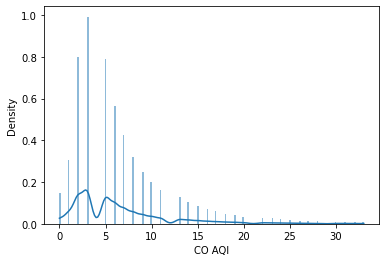

In [13]:
q2 = data_california['CO AQI'].quantile(0.99)
CO_outliers = data_california[data_california['CO AQI'] > q2]
data_california = data_california.drop(CO_outliers.index, axis= 0)
sns.histplot(data_california['CO AQI'], kde=True, stat="density", linewidth=0)

<AxesSubplot:xlabel='SO2 AQI', ylabel='Density'>

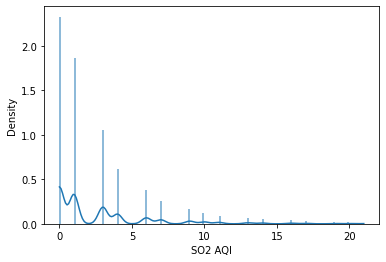

In [14]:
q3 = data_california['SO2 AQI'].quantile(0.99)
SO2_outliers = data_california[data_california['SO2 AQI'] > q3]
data_california = data_california.drop(SO2_outliers.index, axis= 0)
sns.histplot(data_california['SO2 AQI'], kde=True, stat="density", linewidth=0)

<AxesSubplot:xlabel='NO2 AQI', ylabel='Density'>

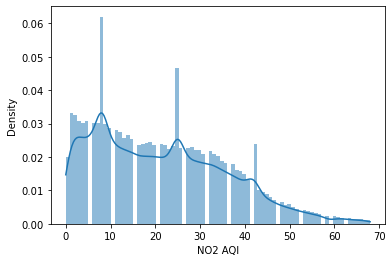

In [15]:
q4 = data_california['NO2 AQI'].quantile(0.99)
NO2_outliers = data_california[data_california['NO2 AQI'] > q4]
data_california = data_california.drop(NO2_outliers.index, axis= 0)
sns.histplot(data_california['NO2 AQI'], kde=True, stat="density", linewidth=0)

## Averaging the same dates

In [16]:
#Average O3 AQI in a county and city
data_cali = data_california.groupby(['State', 'Date']).mean()
data_cali.rename(columns = {'O3 AQI':'Average O3 AQI', 'SO2 AQI': 'Average SO2 AQI', 'CO AQI': 'Average CO AQI', 'NO2 AQI':'Average NO2 AQI'}, inplace = True)
data_cali = data_cali.reset_index(level = [0,1])
data_cali

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
0,California,2000-01-01,28.368421,9.526316,4.736842,22.105263
1,California,2000-01-02,31.750000,8.750000,3.900000,24.300000
2,California,2000-01-03,19.900000,18.150000,6.150000,36.350000
3,California,2000-01-04,19.823529,16.058824,6.352941,35.176471
4,California,2000-01-05,27.187500,13.312500,4.437500,28.500000
...,...,...,...,...,...,...
7939,California,2021-09-26,34.666667,2.833333,1.166667,3.166667
7940,California,2021-09-27,31.166667,3.000000,0.333333,6.333333
7941,California,2021-09-28,32.833333,2.666667,0.333333,11.000000
7942,California,2021-09-29,27.833333,3.666667,0.833333,16.500000


In [17]:
data_cali.info

<bound method DataFrame.info of            State       Date  Average O3 AQI  Average CO AQI  Average SO2 AQI  \
0     California 2000-01-01       28.368421        9.526316         4.736842   
1     California 2000-01-02       31.750000        8.750000         3.900000   
2     California 2000-01-03       19.900000       18.150000         6.150000   
3     California 2000-01-04       19.823529       16.058824         6.352941   
4     California 2000-01-05       27.187500       13.312500         4.437500   
...          ...        ...             ...             ...              ...   
7939  California 2021-09-26       34.666667        2.833333         1.166667   
7940  California 2021-09-27       31.166667        3.000000         0.333333   
7941  California 2021-09-28       32.833333        2.666667         0.333333   
7942  California 2021-09-29       27.833333        3.666667         0.833333   
7943  California 2021-09-30       41.166667        6.666667         1.166667   

      A

In [18]:
data_cali.tail(5)

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
7939,California,2021-09-26,34.666667,2.833333,1.166667,3.166667
7940,California,2021-09-27,31.166667,3.000000,0.333333,6.333333
7941,California,2021-09-28,32.833333,2.666667,0.333333,11.000000
7942,California,2021-09-29,27.833333,3.666667,0.833333,16.500000
7943,California,2021-09-30,41.166667,6.666667,1.166667,21.000000


In [19]:
data_cali.head(15)

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
0,California,2000-01-01,28.368421,9.526316,4.736842,22.105263
1,California,2000-01-02,31.750000,8.750000,3.900000,24.300000
2,California,2000-01-03,19.900000,18.150000,6.150000,36.350000
3,California,2000-01-04,19.823529,16.058824,6.352941,35.176471
4,California,2000-01-05,27.187500,13.312500,4.437500,28.500000
5,California,2000-01-06,21.333333,15.666667,6.500000,35.388889
6,California,2000-01-07,20.933333,15.333333,7.333333,34.266667
7,California,2000-01-08,19.882353,15.647059,5.705882,30.470588
8,California,2000-01-09,25.357143,11.428571,3.714286,24.857143
9,California,2000-01-10,21.937500,10.250000,3.250000,25.437500


## Data Visualization & Analysis of Correlation between Gases

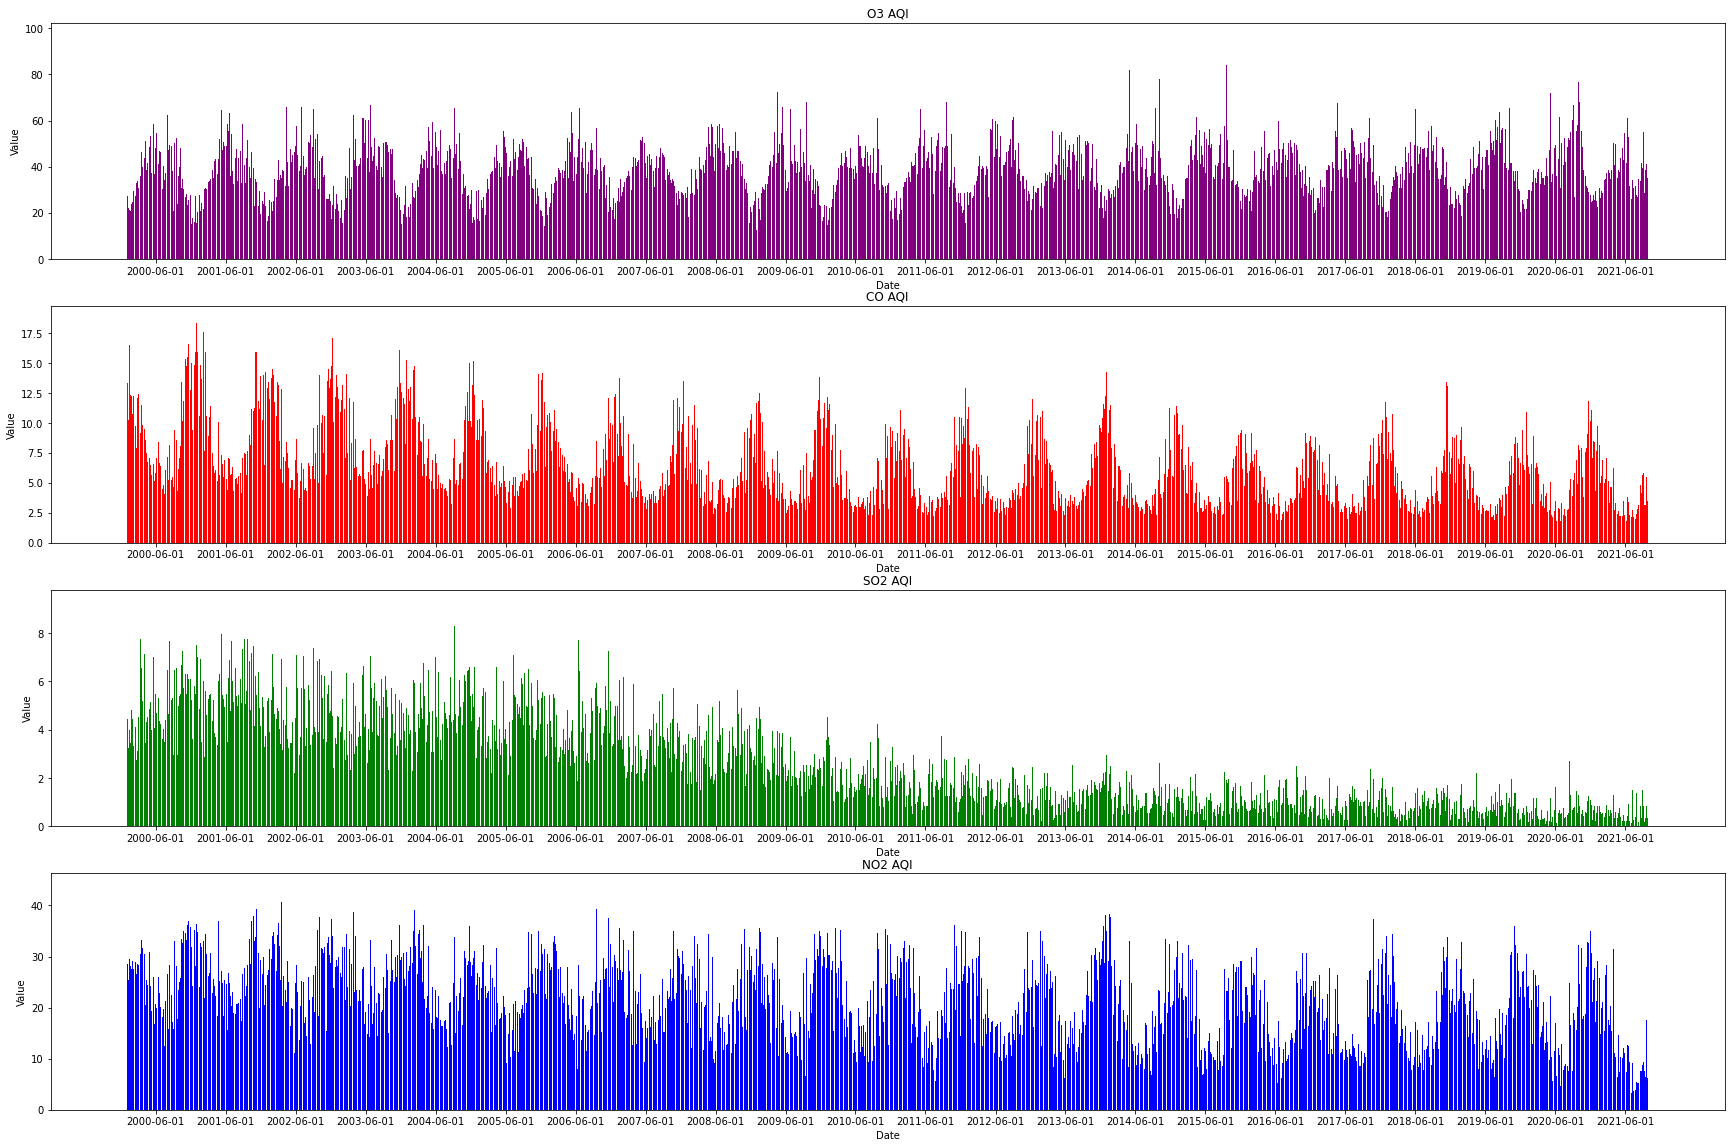

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (30,20)) 
for ax in ax1, ax2, ax3, ax4:
    ax.set(xlabel='Date')
    ax.set(ylabel='Value')

ax1.bar(data_cali['Date'], data_cali['Average O3 AQI'], color = 'purple')
ax1.set_title('O3 AQI')
ax1.set_xticks(['2000-06','2001-06','2002-06','2003-06','2004-06','2005-06','2006-06','2007-06','2008-06','2009-06','2010-06','2011-06','2012-06','2013-06','2014-06','2015-06','2016-06','2017-06','2018-06','2019-06','2020-06','2021-06']) 

ax2.bar(data_cali['Date'], data_cali['Average CO AQI'], color = 'red')
ax2.set_title('CO AQI')
ax2.set_xticks(['2000-06','2001-06','2002-06','2003-06','2004-06','2005-06','2006-06','2007-06','2008-06','2009-06','2010-06','2011-06','2012-06','2013-06','2014-06','2015-06','2016-06','2017-06','2018-06','2019-06','2020-06','2021-06']) 

ax3.bar(data_cali['Date'], data_cali['Average SO2 AQI'], color = 'green')
ax3.set_title('SO2 AQI')
ax3.set_xticks(['2000-06','2001-06','2002-06','2003-06','2004-06','2005-06','2006-06','2007-06','2008-06','2009-06','2010-06','2011-06','2012-06','2013-06','2014-06','2015-06','2016-06','2017-06','2018-06','2019-06','2020-06','2021-06']) 

ax4.bar(data_cali['Date'], data_cali['Average NO2 AQI'], color = 'blue')
ax4.set_title('NO2 AQI')
ax4.set_xticks(['2000-06','2001-06','2002-06','2003-06','2004-06','2005-06','2006-06','2007-06','2008-06','2009-06','2010-06','2011-06','2012-06','2013-06','2014-06','2015-06','2016-06','2017-06','2018-06','2019-06','2020-06','2021-06'])
plt.show()

While observing the reoccuring seasonal patterns for all of the four air quality index categories in California, for O3, CO and NO2 we see that values are fairly spread in comparison to SO2 and the overall measured values tend to have declined over the last years with the exception of O3. In general, pollution appears to be highest in summer and lowest in winter.

In [21]:
data_cali.corr()

,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
Average O3 AQI,1.000000,-0.491114,-0.031924,-0.303733
Average CO AQI,-0.491114,1.000000,0.549013,0.855975
Average SO2 AQI,-0.031924,0.549013,1.000000,0.556104
Average NO2 AQI,-0.303733,0.855975,0.556104,1.000000


<AxesSubplot:>

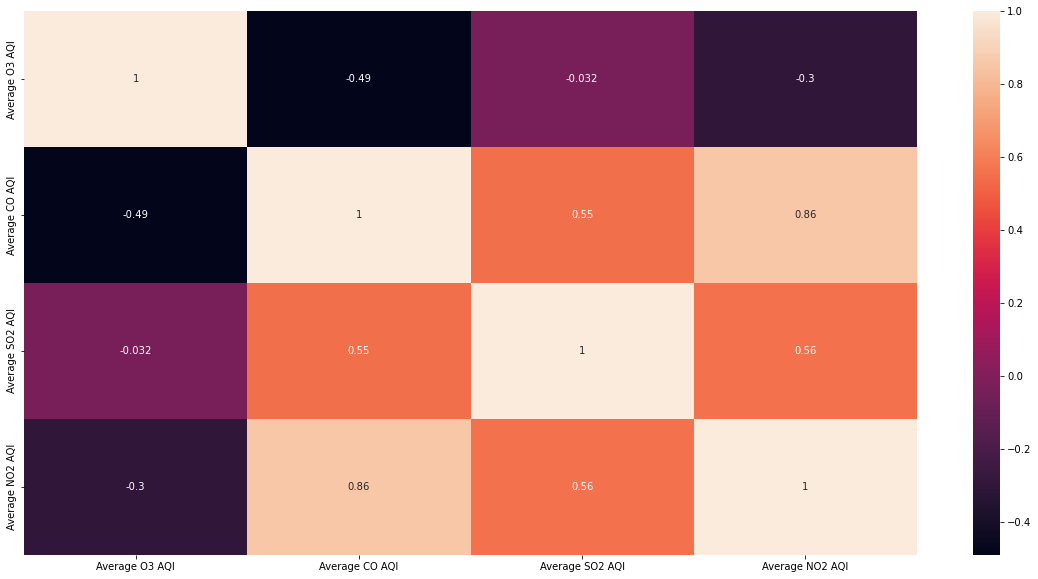

In [22]:
plt.figure(figsize = (20,10))
sns.heatmap(data_cali.corr(), annot = True)

I'm using heatmap as it helps display a graphical representation of the data with the correlation between each of the greenhouse gases. From the graph, I can see that there is a very strong positive relationship between the gases CO and NO2. There is also strong positive relationship between the gases SO2 and NO2, and a moderate relationship between the gases CO and SO2.

## Plotting Correlation

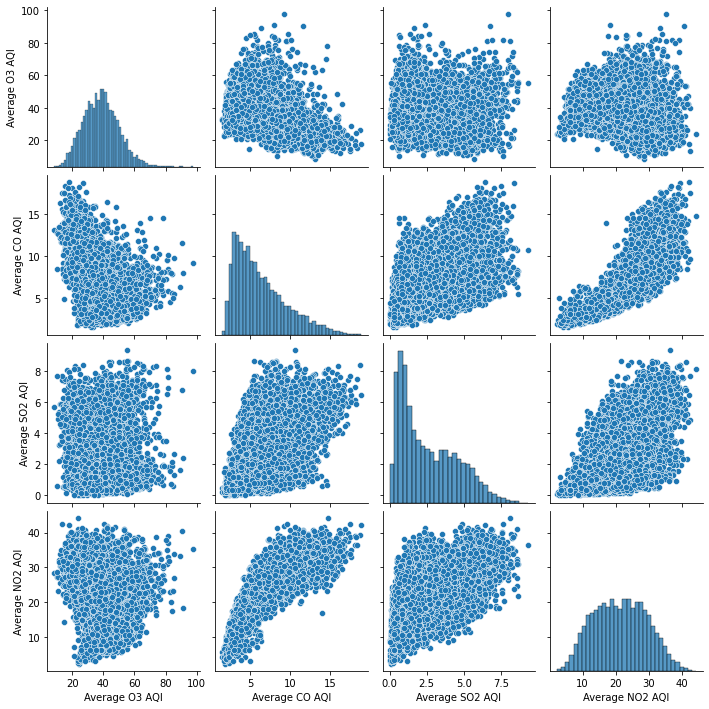

In [23]:
sns.pairplot(data_cali)
plt.show()

Linear relationships can only be (to some extent) observed between NO2 and CO, NO2 and SO2, and CO and SO2.

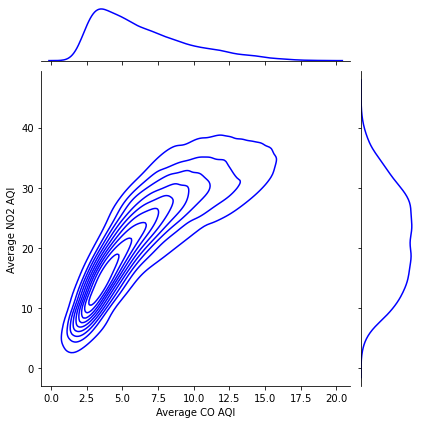

In [24]:
sns.jointplot(x = 'Average CO AQI', y = 'Average NO2 AQI', data = data_cali, kind = 'kde', color = 'blue')
plt.show()

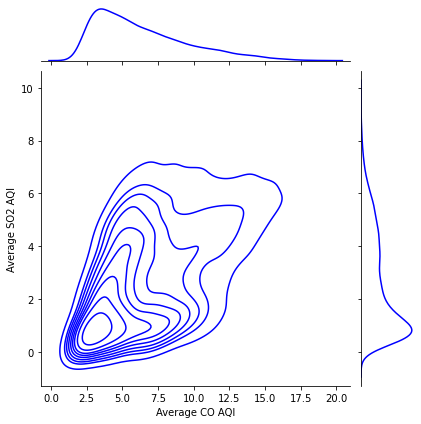

In [25]:
sns.jointplot(x = 'Average CO AQI', y = 'Average SO2 AQI', data = data_cali, kind = 'kde', color = 'blue')
plt.show()

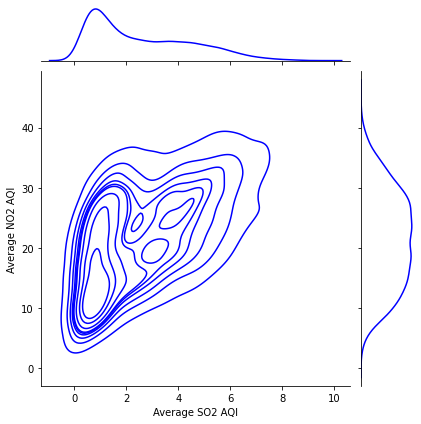

In [26]:
sns.jointplot(x = 'Average SO2 AQI', y = 'Average NO2 AQI', data = data_cali, kind = 'kde', color = 'blue')
plt.show()

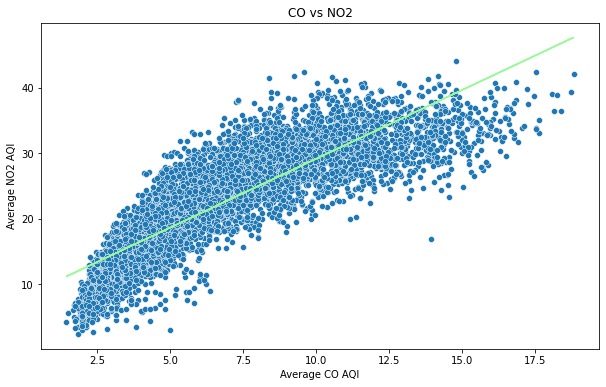

The slope of the linear regression is [2.1034119]


In [27]:
fig, ax = plt.subplots(figsize=(10,6))
regr = LinearRegression()
x = np.array(data_cali['Average CO AQI']).reshape(-1,1)
y = np.array(data_cali['Average NO2 AQI']).reshape(-1,1)
fitting = regr.fit(x, y)
slope = fitting.coef_[0]
sns.scatterplot(data = data_cali, x = 'Average CO AQI', y = 'Average NO2 AQI').set(title = 'CO vs NO2')
plt.plot(x, fitting.predict(x), color = 'palegreen')
plt.show()
print("The slope of the linear regression is {}".format(slope))

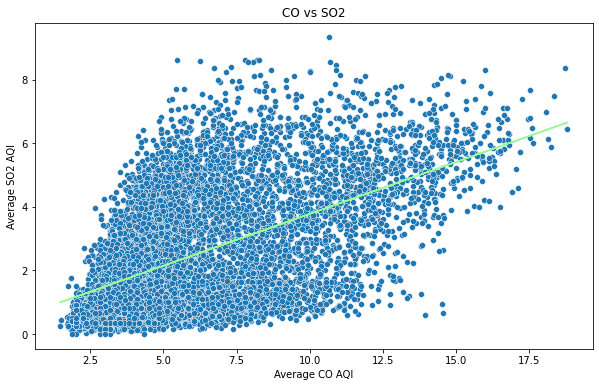

The slope of the linear regression is [0.32624318]


In [28]:
fig, ax = plt.subplots(figsize=(10,6))
regr = LinearRegression()
x = np.array(data_cali['Average CO AQI']).reshape(-1,1)
y = np.array(data_cali['Average SO2 AQI']).reshape(-1,1)
fitting = regr.fit(x, y)
slope = fitting.coef_[0]
sns.scatterplot(data = data_cali, x = 'Average CO AQI', y = 'Average SO2 AQI').set(title = 'CO vs SO2')
plt.plot(x, fitting.predict(x), color = 'palegreen')
plt.show()
print("The slope of the linear regression is {}".format(slope))

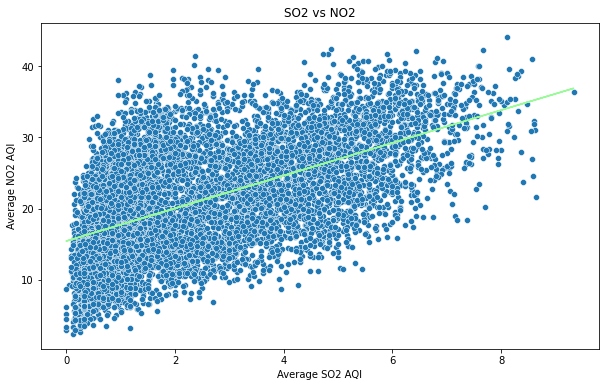

The slope of the linear regression is [2.29964713]


In [29]:
fig, ax = plt.subplots(figsize=(10,6))
regr = LinearRegression()
x = np.array(data_cali['Average SO2 AQI']).reshape(-1,1)
y = np.array(data_cali['Average NO2 AQI']).reshape(-1,1)
fitting = regr.fit(x, y)
slope = fitting.coef_[0]
sns.scatterplot(data = data_cali, x = 'Average SO2 AQI', y = 'Average NO2 AQI').set(title = 'SO2 vs NO2')
plt.plot(x, fitting.predict(x), color = 'palegreen')
plt.show()
print("The slope of the linear regression is {}".format(slope))

## Monthly Data

In [30]:
# Monthly Data Average
monthly_data_cali = data_cali.groupby('State').resample('1M', label = 'right', closed = 'right', on = 'Date').mean().reset_index().sort_values(by = 'Date')
monthly_data_cali

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
0,California,2000-01-31,20.799990,13.136601,4.907754,28.927184
1,California,2000-02-29,29.432550,10.523901,3.998811,28.017219
2,California,2000-03-31,38.187217,9.145068,5.038055,28.661404
3,California,2000-04-30,43.450170,7.730233,4.955956,25.670958
4,California,2000-05-31,45.868926,6.358298,5.276247,23.110310
...,...,...,...,...,...,...
256,California,2021-05-31,45.725497,2.694417,0.396845,11.362520
257,California,2021-06-30,43.471059,2.889608,0.422865,12.567462
258,California,2021-07-31,27.612903,2.143433,0.623848,4.930876
259,California,2021-08-31,36.094624,4.202151,0.688172,7.369892


<AxesSubplot:>

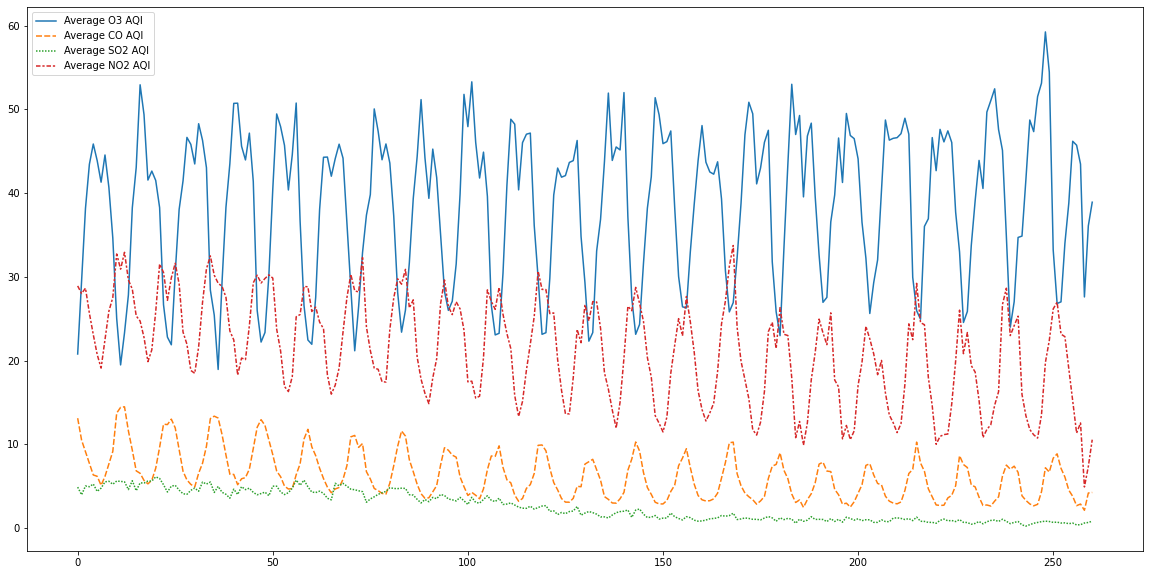

In [31]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = monthly_data_cali)

The chart represent the relatively wide-spread records of NO2 and O3. The graph shows that their monthly means lie between 20-30 parts per billion and 20-50 parts per million, respectively.

In [32]:
monthly_data_cali.shape

(261, 6)

In [33]:
monthly_data_cali['Average O3 AQI'].head()

0    20.799990
1    29.432550
2    38.187217
3    43.450170
4    45.868926
Name: Average O3 AQI, dtype: float64

## Time Series Model

### Hyperparameters


In [34]:
n_epochs = 2000                   
batch_size = 1                    # There is only 1 time series data. No other choice but 1. 
learn_rate = 0.0001
n_input = 1                       # Scalar input.
n_neurons = 100                   # N# of neurons per layer.
n_output = 1                      # Scalar output.
n_ts_seed = 20                    # Seed length.
n_predict_time_steps = 300
rmse = []
TS = []

###  Exponential smoothing method and predict

#### O3

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


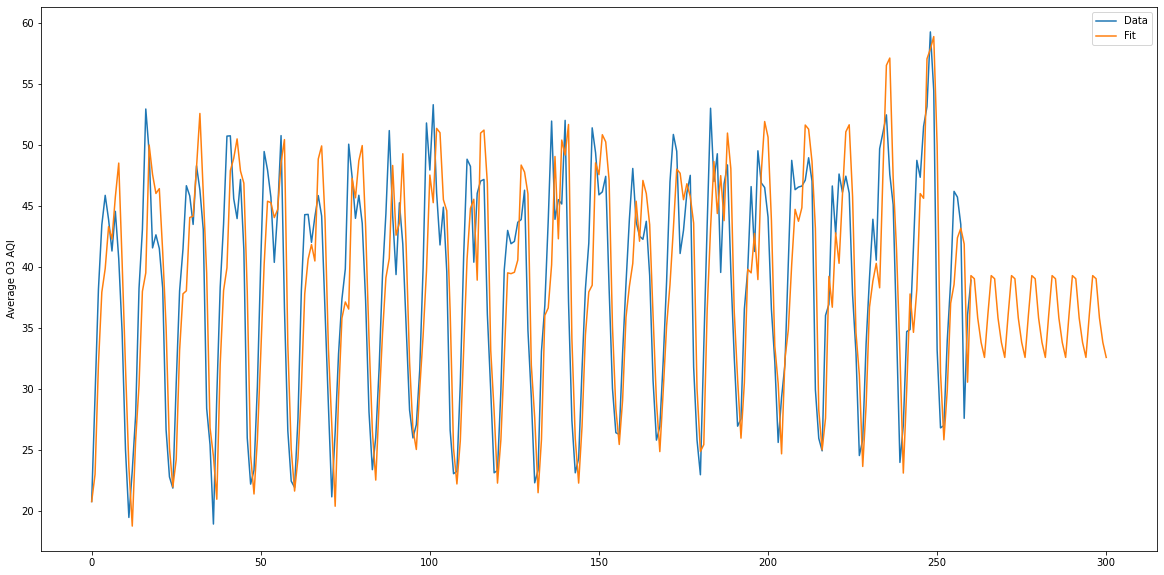

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average O3 AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average O3 AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

#### CO

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


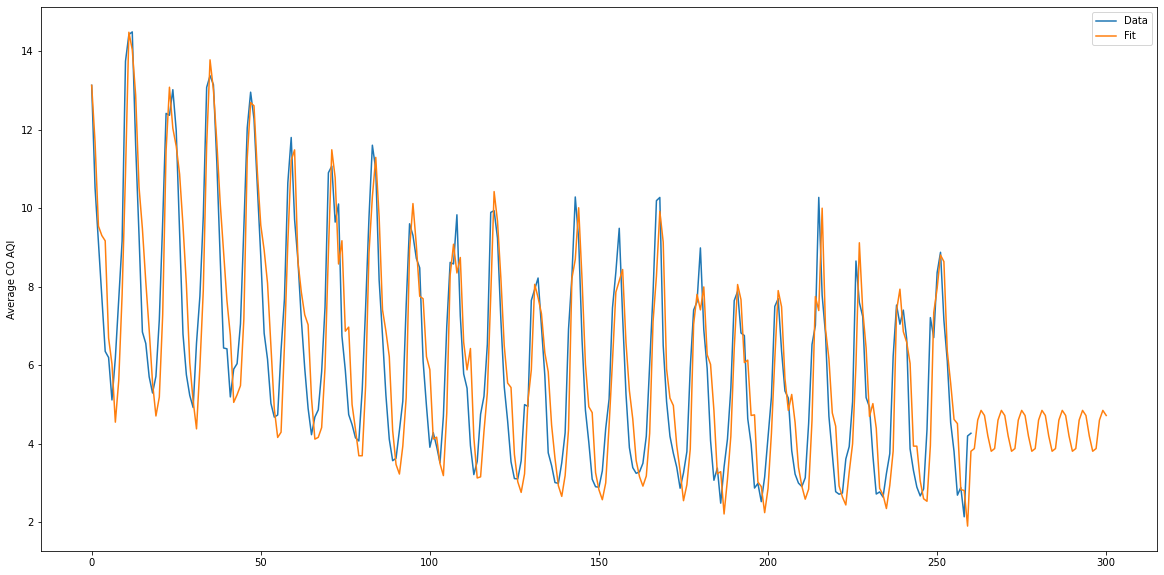

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average CO AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average CO AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

#### SO2

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


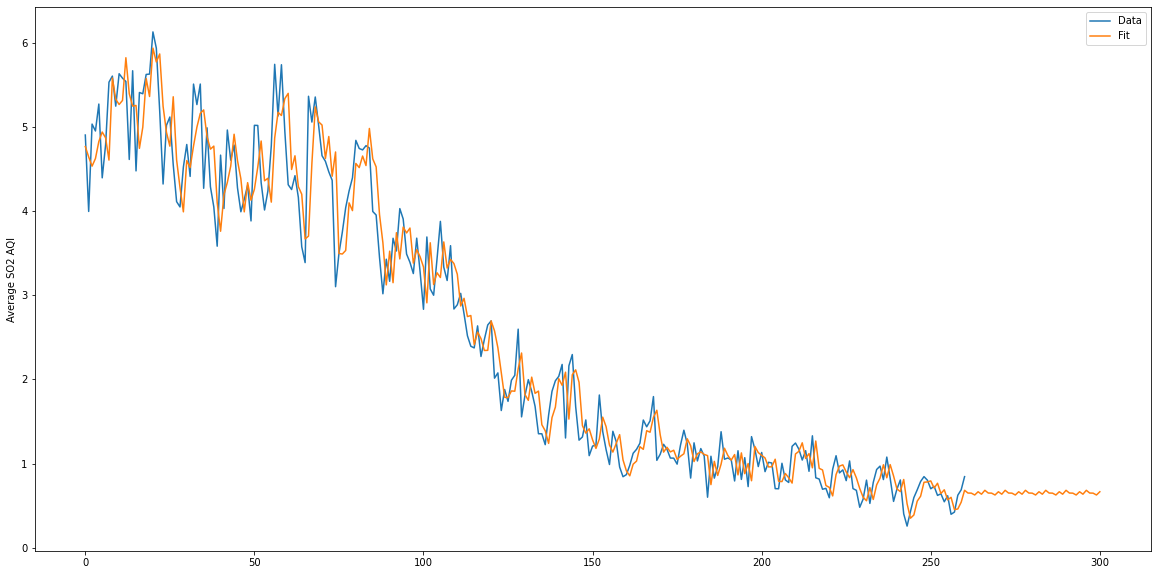

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average SO2 AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average SO2 AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

#### NO2

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


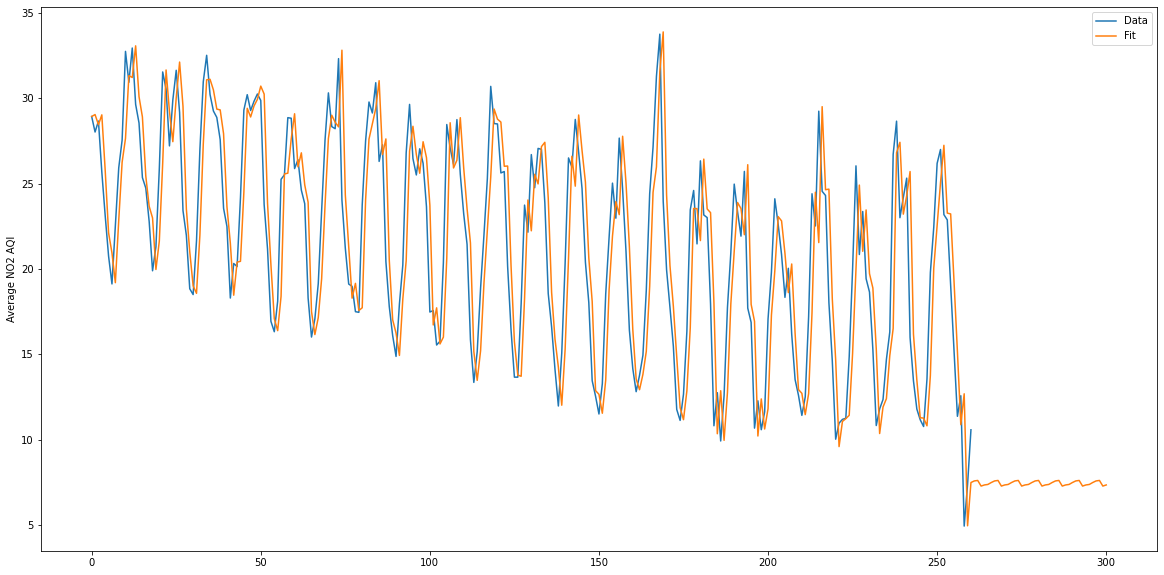

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average NO2 AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average NO2 AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

## Recurrent Neural Network (RNN)

### Preprocessing

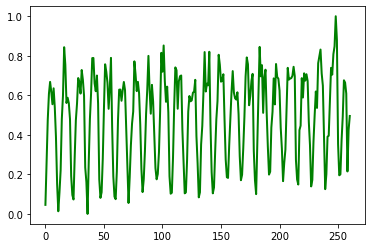

In [39]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average O3 AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [40]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1) #Reshaping

### Model

In [41]:
my_model_O3 = Sequential()
my_model_O3.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_O3.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [42]:
my_model_O3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          101       
 ibuted)                                                         
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Define the optimizer and compile.
my_optimizer = Adam(learning_rate = learn_rate)
my_model_O3.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

### Train the model

In [44]:
# Separate the training history and combine the time series plots 
my_summary_O3 = my_model_O3.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [45]:
my_summary_O3.history.keys()

dict_keys(['loss', 'mse'])

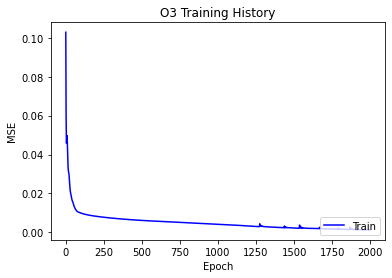

In [46]:
plt.plot(my_summary_O3.history['mse'], c="b")
plt.title('O3 Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

### Prediction

In [47]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_O3.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

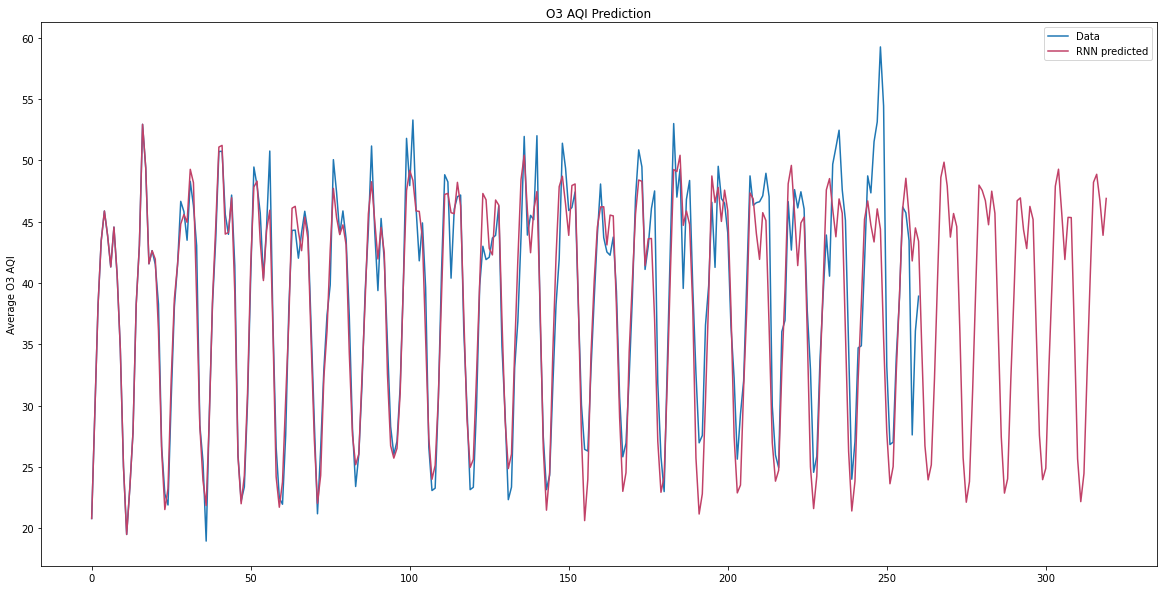

In [48]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average O3 AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("O3 AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

In [49]:
mse_O3 = mean_squared_error(monthly_data_cali['Average O3 AQI'], ts[0:261])
rmse_O3 = sqrt(mse_O3)
print('The Root Mean Squared Error of O3 forecast is {}'.format(round(rmse_O3, 2)))
rmse.append(round(rmse_O3, 2))
TS.append(ts[261:300])

The Root Mean Squared Error of O3 forecast is 3.37


## Repeat for CO, SO2, NO2 AQI

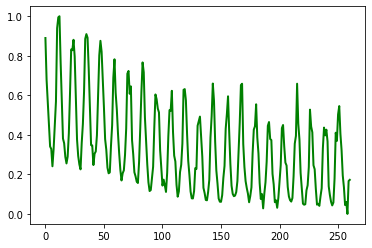

In [50]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average CO AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [51]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1)

In [52]:
my_model_CO = Sequential()
my_model_CO.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_CO.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [53]:
my_model_CO.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1)          101       
 tributed)                                                       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [54]:
my_model_CO.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [55]:
my_summary_CO = my_model_CO.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [56]:
my_summary_CO.history.keys()

dict_keys(['loss', 'mse'])

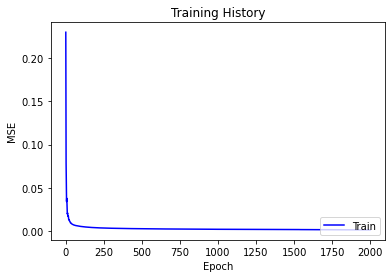

In [57]:
plt.plot(my_summary_CO.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [58]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_CO.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

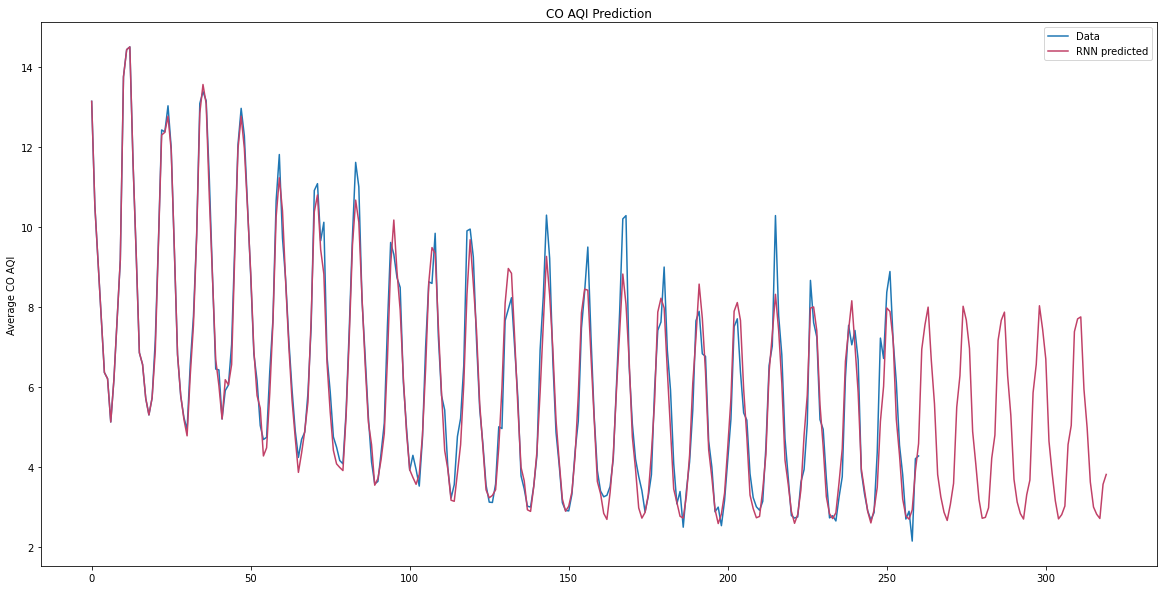

In [59]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average CO AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("CO AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

In [60]:
mse_CO = mean_squared_error(monthly_data_cali['Average CO AQI'], ts[0:261])
rmse_CO = sqrt(mse_CO)
print('The Root Mean Squared Error of CO forecast is {}'.format(round(rmse_CO, 2)))
rmse.append(round(rmse_CO, 2))
TS.append(ts[261:300])

The Root Mean Squared Error of CO forecast is 0.5


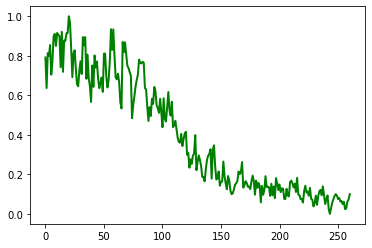

In [61]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average SO2 AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [62]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1)

In [63]:
my_model_SO2 = Sequential()
my_model_SO2.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_SO2.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [64]:
my_model_SO2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 1)          101       
 tributed)                                                       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [65]:
my_model_SO2.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [66]:
my_summary_SO2 = my_model_SO2.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [67]:
my_summary_SO2.history.keys()

dict_keys(['loss', 'mse'])

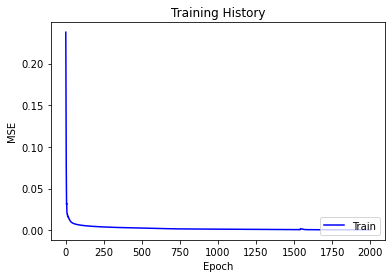

In [68]:
plt.plot(my_summary_SO2.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [69]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_SO2.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

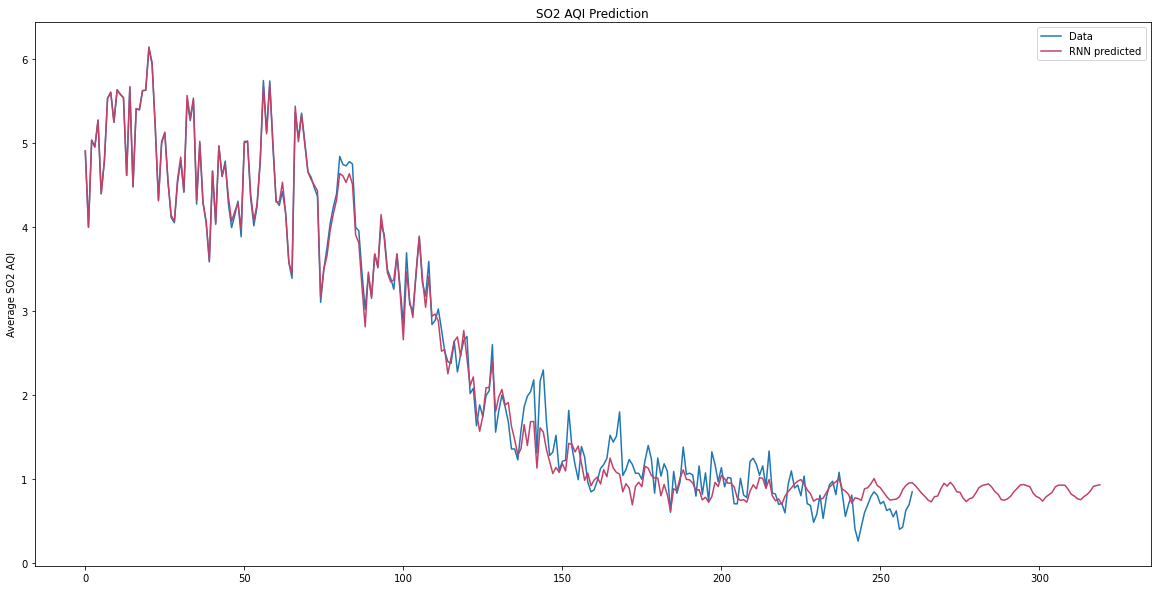

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average SO2 AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("SO2 AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

In [71]:
mse_SO2 = mean_squared_error(monthly_data_cali['Average SO2 AQI'], ts[0:261])
rmse_SO2 = sqrt(mse_SO2)
print('The Root Mean Squared Error of SO2 forecast is {}'.format(round(rmse_SO2, 2)))
rmse.append(round(rmse_SO2, 2))
TS.append(ts[261:300])

The Root Mean Squared Error of SO2 forecast is 0.18


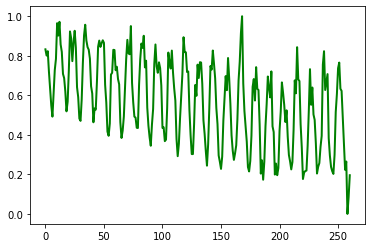

In [72]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average NO2 AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [73]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1)

In [74]:
my_model_NO2 = Sequential()
my_model_NO2.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_NO2.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [75]:
my_model_NO2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1)          101       
 tributed)                                                       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [76]:
my_model_NO2.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [77]:
my_summary_NO2 = my_model_NO2.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [78]:
my_summary_NO2.history.keys()

dict_keys(['loss', 'mse'])

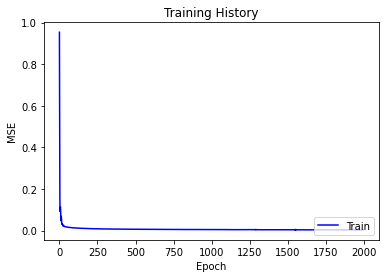

In [79]:
plt.plot(my_summary_NO2.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [80]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_NO2.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

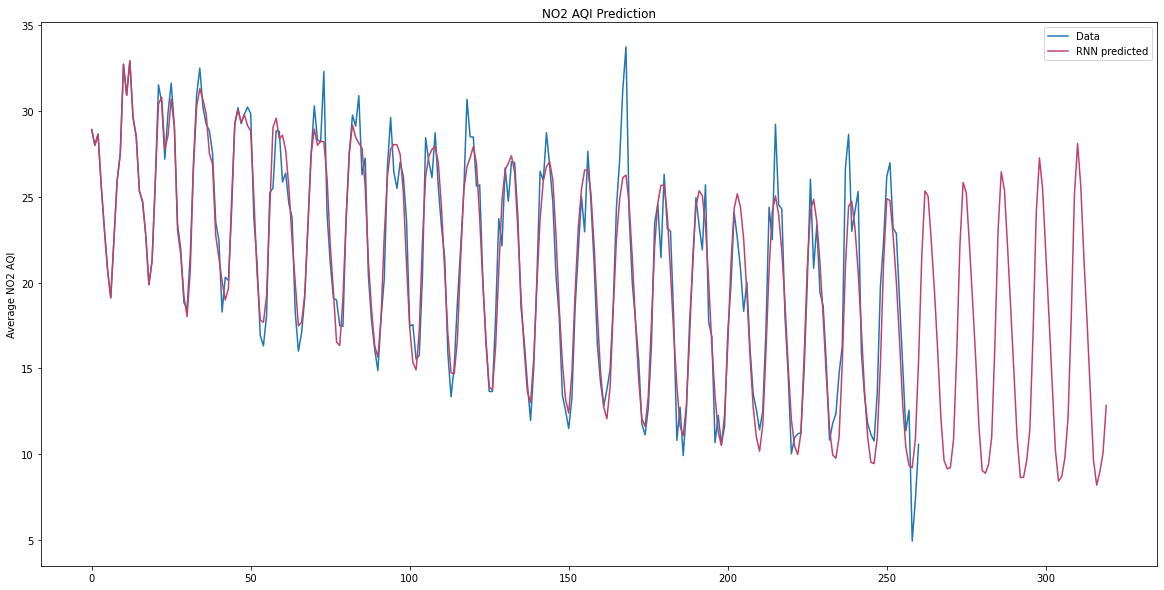

In [81]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average NO2 AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("NO2 AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

In [82]:
mse_NO2 = mean_squared_error(monthly_data_cali['Average NO2 AQI'], ts[0:261])
rmse_NO2 = sqrt(mse_NO2)
print('The Root Mean Squared Error of NO2 forecast is {}'.format(round(rmse_NO2, 2)))
rmse.append(round(rmse_NO2, 2))
TS.append(ts[261:300])

The Root Mean Squared Error of NO2 forecast is 1.74


### Error Analysis

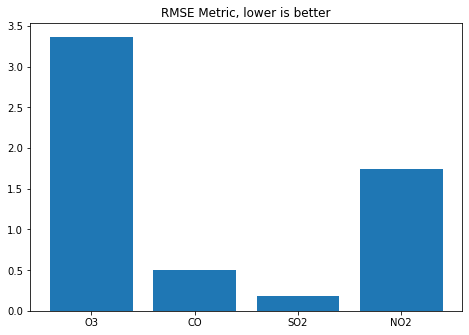

[3.37, 0.5, 0.18, 1.74]


In [83]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
AQIs = ['O3', 'CO', 'SO2', 'NO2']
ax.bar(AQIs, rmse)
plt.title('RMSE Metric, lower is better')
plt.show()
print(rmse)

The Root Mean Square Error(RMSE) for O3 is quite high, which is reflected by the the model not clearly capturing the seasonality of the AQI. Thus, it's fair to assume that the prediction for O3 is not accurate. 

### Data and Prediction Analysis

The tests that we chose to use on the data to determine whether the lifting of the lockdown affected the four AQIs were 2 sample t-test for O3, CO, and NO2. This is because we are using two independent distributions of original and predicted data that are normally distributed. We used the Mann-Whitney test for SO2 AQI because the data for SO2 was not normally distributed. 

In [84]:
predicted_O3 = TS[0]
stats.ttest_ind(monthly_data_cali['Average O3 AQI'], predicted_O3, equal_var=False)

Ttest_indResult(statistic=array([0.71500088]), pvalue=array([0.47799277]))

The 2 sample t-test for O3 has a p-value of 0.478 which is greater than alpha=0.05 so we fail to reject our null hypothesis that there is difference between pre-covid O3 AQI values and post-covid O3 AQI values. However, this may not be held true as the error for the predicted values of O3 AQI is large, which affects the accuracy. Thus, there is insufficient statistically significant evicence to suggest that O3 AQI post covid would have similar trends during pre-covid times.

In [85]:
predicted_CO = TS[1]
stats.ttest_ind(monthly_data_cali['Average CO AQI'], predicted_CO, equal_var=False)

Ttest_indResult(statistic=array([3.41008523]), pvalue=array([0.00112567]))

The 2 sample t-test for CO has a p-value of 0.00112567 which is smaller than alpha=0.05 so we reject our null hypothesis that there is difference between pre-covid CO AQI values and post-covid CO AQI values. There is sufficient statistically significant evicence to suggest that CO AQI post covid would have similar trends during pre-covid times.

In [86]:
predicted_SO2 = TS[2]
stats.mannwhitneyu(monthly_data_cali['Average SO2 AQI'], predicted_SO2, alternative='two-sided')

MannwhitneyuResult(statistic=array([8519.]), pvalue=array([1.15179775e-11]))

The Mann-Whitney test for SO2 has a p-value of 1.15179775e-11 which is smaller than alpha=0.05 so we reject our null hypothesis that there is difference between pre-covid SO2 AQI values and post-covid SO2 AQI values. There is sufficient statistically significant evicence to suggest that SO2 AQI post covid would have similar trends during pre-covid times.

In [87]:
predicted_NO2 = TS[3]
stats.ttest_ind(monthly_data_cali['Average NO2 AQI'], predicted_NO2, equal_var=False)

Ttest_indResult(statistic=array([3.88881988]), pvalue=array([0.00030427]))

The 2 sample t-test for NO2 has a p-value of 0.00030427 which is smaller than alpha=0.05 so we reject our null hypothesis that there is difference between pre-covid NO2 AQI values and post-covid NO2 AQI values. There is sufficient statistically significant evicence to suggest that NO2 AQI post covid would have similar trends during pre-covid times.

## Conclusion 

After conducting analyses on the four air quality index categories in California, there were some deviations pre-covid data and the predicted post-covid data. However, none of these were significant enough based on the hypothesis tests we conducted except for the O3 AQI(RSME was relatively high, so test is invalid). It is reasonable to say that there was no marked difference in the AQIs potentially based on what's predicted and that any deviations could be attributed to random chance and not necessarily due to the resumption of production and day-to day activities.

- The RNN model somewhat captured all of the four air quality index seasonality in California.
- The prediction for CO and SO2 seemed natural, which is reflected by their RSME values.